<a href="https://colab.research.google.com/github/Aliaksandr-Borsuk/Virtual-internship-from-Sberbank/blob/main/virtual_stajirovka_sber_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- https://coreapp.ai/app/player/lesson/62d97c674a53cd0b6694a698/1/62d97c674a53cd0b6694a69b   

# Постановка задачи


## Условие
  
  
  В приложенном файле представлены подневные данные объема расчетных счетов физических лиц.  
  В отличие от депозита, клиент может снять всю сумму с расчетного счета в любой момент времени без каких-либо «штрафов». Такой продукт называют Undefined Maturity Product – UMP).  
  Однако маловероятно, что все клиенты разом закроют свои счета в Банке. Всегда кто-то снимает деньги, а кто-то пополняет счет – есть некоторый стабильный уровень, ниже которого не опустится суммарный объем расчетных счетов.

  **Итак, кажется пора переходить к задаче.**  
  
Для временного ряда в файле data.csv необходимо построить модель, которая оценивает объем стабильной части средств на дату.


  
Например:
  
**model_forecast**
  
- (2019-02-01, ‘1М’, История_до_2019-02-01) = стабильная часть на 1М

- Возможные горизонты: 1М, 2М, 3М, 4М, 5М, 6М, 7М, 8М, 9М, 10М, 11М, 12М
  
**Критерии качества модели:**
   
Нужно одновременно минимизировать величины:  
   
- максимальный объем пробития стабильный части на валидационной выборке

- фактическая стабильная часть – модельная стабильная часть

    

Можно применять любые подходы. Как вариант: построить квантильную регрессию для прогнозирования ряда.

## Размышления над заданием

### Метрика  
  
  Так как нам необходимо минимизировать две величины,
  - масимальный объём пробития ( я не знаю как правильно это  назвать на английском , назову - maximum breakthrough volume **MBV**)
  - излишняя стабильная часть ( назовём её - excess stock **ES**)   
  то и метрика должна их учитывать обе. Самое простое - взвешенная сумма (weighted sum)  
    
  $WA = \alpha*MBV + (1-\alpha)*ES$
    
Где коэффициент $0<\alpha<1$ регулирует вес каждой из ошибок.   
  
 Так же можно использовать и другие метрики , например - средневзвешенное гармоническое или придумать что-то нестандартное.  
   
 Кмк, для банка важно  иметь возможность сместить приоритеты к большей минимизации MBV или ES.
    
Понятно , что объём пробития это
   
  -    -1* (фактическая стабильная часть – модельная стабильная часть)  
         
тогда, когда фактическая стабильная часть меньше машинной.  
   Т.е. по итогу, нам нужно минимизировать абсолютную ошибку для одного показателя за прогнозируемый период.
  Единственный ньюанс - нам бы хотелось **MBV** и **ES** учитывать взвешенно. И вот рекомендованная  квантильная регрессия именно этим и занимается! Она по разному взвешивает потери для положительных и отрицательных ошибок для различных персентилей.  
     
  Потери в квантильной регрессии для отдельной точки данных определяются как:  
    
 **$\mathscr{L}(\xi_i|\alpha)=
  \begin{cases}
    \alpha*\xi_i      & \quad \text{if }  \xi_i \geq 0\\
    (\alpha-1)*\xi_i  & \quad \text{if } \xi_i < 0
  \end{cases}$**
   
  Квантильные потери различаются в зависимости от оцениваемого персентиля, так что большее количество отрицательных ошибок наказывается сильнее для более высоких персентилей, а  положительные ошибки наказываются сильнее для более низких.

   

###  План решения задачи
- Построим простую модель для выполнения данной задачи по следующему плану
  
- - Схлопываем датасет до требуемой размерности горизонта
- - пытаемся предсказать на один горизонт вперёд  с помощью модели квантиьной регрессии.  
- изменяя персентиль модели мы можем придавать больший вес ошибке объёма пробития, или ошибке предсказания фактической стабильной части


# Решение

## Загрузки

In [ ]:
# загрузка файла
import gdown

url = 'https://drive.google.com/uc?id=1fXcMfN8THZtK-qk-64KFD9Pqkn1WZvXH'
output = 'data.csv'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1fXcMfN8THZtK-qk-64KFD9Pqkn1WZvXH
To: /content/data.csv
100%|██████████| 50.6k/50.6k [00:00<00:00, 25.5MB/s]


'data.csv'

In [ ]:
# импорт библиотек
import pandas as pd
import numpy as np
from pathlib import Path

import scipy.stats as stats
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns


import warnings
warnings.filterwarnings("ignore")

In [ ]:
# настройка картинок
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(14, 3))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)


## Light EDA

In [ ]:
# чтение данных
data = pd.read_csv('data.csv',
                   delimiter=';', parse_dates=['REPORTDATE'], dayfirst=True)
print(f'Дубликаты - {data.duplicated().sum()} \n Размер - {data.shape}',  '\n')
display(data.head(2))
data.tail(3)

Дубликаты - 0 
 Размер - (2111, 2) 



,REPORTDATE,VALUE
0,2013-12-30,3457625638
1,2013-12-31,3417092149


,REPORTDATE,VALUE
2108,2019-10-08,68424049766
2109,2019-10-09,72492897583
2110,2019-10-10,72307860851


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   REPORTDATE  2111 non-null   datetime64[ns]
 1   VALUE       2111 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 33.1 KB


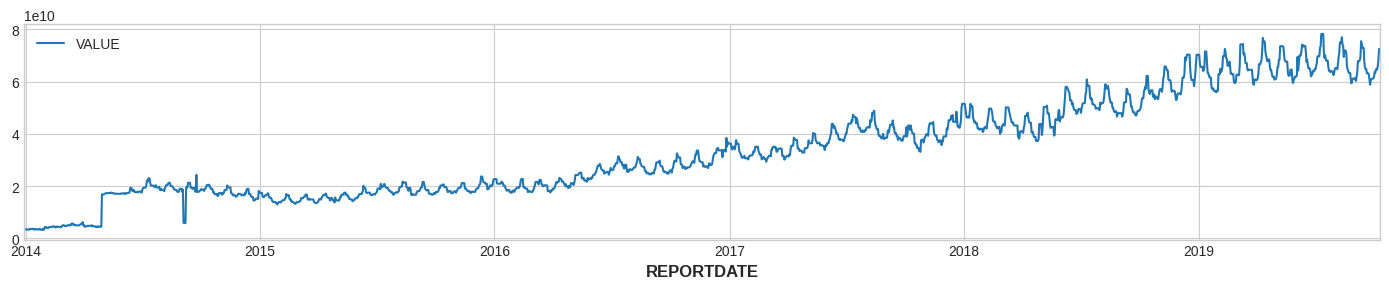

In [ ]:
fig, ax=plt.subplots()
data.set_index('REPORTDATE').plot(ax =ax)
plt.show()

### Первые выводы
- имеем две колонки
    - дата и сумма на счетах
- дата с 30 декабря 2013 по 09 декабря 2019
- всего 2 111 записей
- дубликатов нет
- потеряных значений нет
- имеем временной ряд
- явно заметен тренд (матожидание увеличивается), что говорит о нестационарности ряда.
- так же явно заметно влияние резкой девальвации рубля 2014-2015 года.
  
**Принятое решение**
- удалить дпнные до 2015 года, так как они сформированы под  сильным  влиянием экзогенныго фактора который мы не будем учитывать.
- т.к. в задании отсутствует пункт о проведении глубокого анализа данных, то и не будем тратить на него время, т.к. проведённого предварительного анализа достаточно для выполнения главной задачи.

### Удаление ненужного.

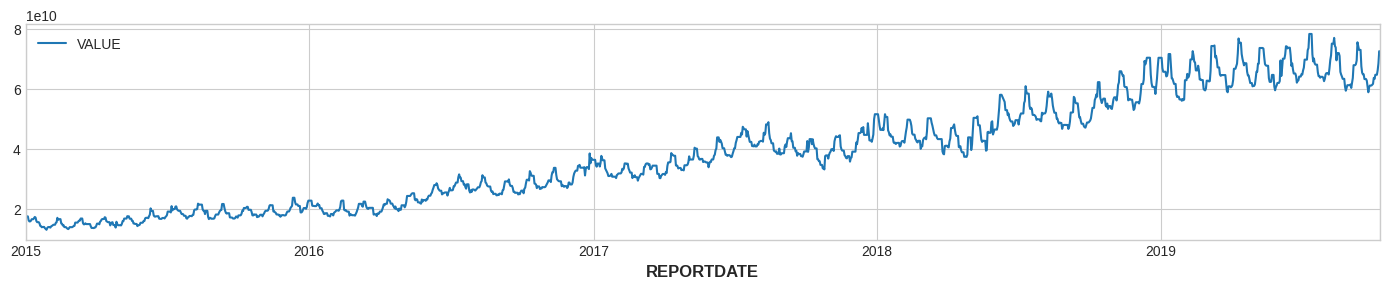

In [ ]:
# обрежем данные
cropped_df = data[data['REPORTDATE']>='2015-01-01'].set_index('REPORTDATE')

fig, ax=plt.subplots()
cropped_df.plot(ax =ax)
plt.show()

## Построение модели.
Поставлена задача построить модель которая оценивает объем стабильной части средств на дату с определённым горизонтом.
Рекомендована __[квантильная регрессия](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.QuantileRegressor.html)__ .   
  
Посмотрим как она делает предсказания в частном случае для разных персентилей.

### пример работы QuantileRegressor

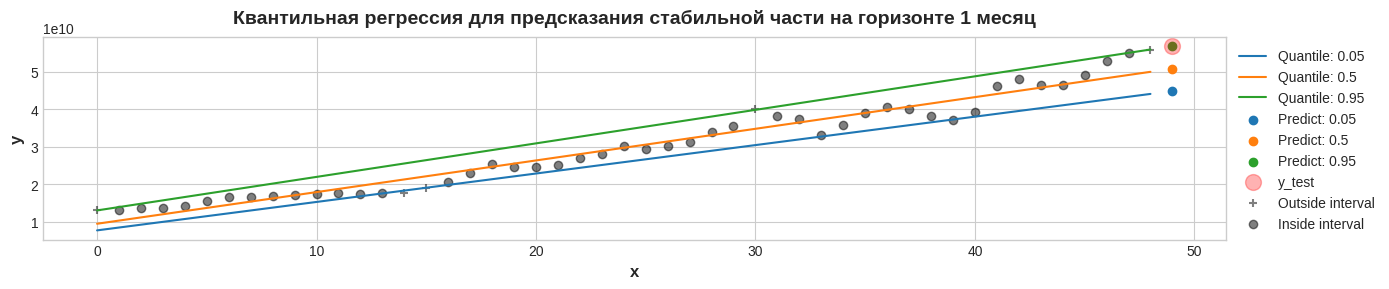

In [ ]:
#  Квантильная регрессия
from sklearn.linear_model import QuantileRegressor

# рассмотрим работу QR для горизонта 1M
# истоия до 2019-02-01
df_res = cropped_df.resample('M').agg('min')
limit = '2019-02-01'
y_test = df_res[df_res.index>=limit].iloc[0,0]
df_res = df_res[df_res.index<limit]

y= df_res.VALUE

x=np.arange(len(df_res))
X = x[:, np.newaxis]
X_test = np.array([[df_res.shape[0]]])

quantiles = [0.05, 0.5, 0.95]
# словарь - предсказания для каждой квантили
predictions = {}
pred_test = {}

out_bounds_predictions = np.zeros_like(y, dtype=np.bool_)

for quantile in quantiles:
    # модель
    qr = QuantileRegressor(quantile=quantile, alpha=0, solver="highs")
    y_pred = qr.fit(X, y).predict(X)
    # складываем в кучку
    predictions[quantile] = y_pred


    if quantile == min(quantiles):
        out_bounds_predictions = np.logical_or(
            out_bounds_predictions, y_pred >= y
        )
    elif quantile == max(quantiles):
        out_bounds_predictions = np.logical_or(
            out_bounds_predictions, y_pred <= y
        )
    y_test = qr.predict(X_test)
    pred_test[quantile] = y_test

# отрисовка

for quantile, y_pred in predictions.items():
    plt.plot(X, y_pred, label=f"Quantile: {quantile}")
for quantile, y_ in pred_test.items():
    plt.scatter(X_test[0], y_, label=f"Predict: {quantile}")

plt.scatter(X_test[0],
            y_test,
            label=f"y_test",
            c='red',
            alpha=0.3,
            s = 130,
            )

plt.scatter(
    x[out_bounds_predictions],
    y[out_bounds_predictions],
    color="black",
    marker="+",
    alpha=0.5,
    label="Outside interval",
)
plt.scatter(
    x[~out_bounds_predictions],
    y[~out_bounds_predictions],
    color="black",
    alpha=0.5,
    label="Inside interval",
)

plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.xlabel("x")
plt.ylabel("y")
_ = plt.title("Квантильная регрессия для предсказания стабильной части на горизонте 1 месяц")

### Построим простую модель.
По дефолту задаём модель с низкой персентилью в 5% эта модель страхуется от большого пробития .  
   
В методе forecast можно переопределить модель, так же можно подавать историю (любой временной ряд,  в виде  датафрейма аналогичного cropped_df), а можно и не подавать, модель сама вырежет историю из cropped_df.

In [ ]:
# Простая модель
class SimpleModel:
    def __init__(self):
        pass

    def forecast(self,
                 limit = '2019-02-01',
                 horizon = '1M',
                 history = cropped_df,
                 model = QuantileRegressor(
                     quantile=0.05, alpha=0, solver="highs"
                 )):
        train = history[history.index<limit]
        # приводим к датасету содержащему только
        # стабильную часть вкладов для требуемого горизонта
        train = train.resample(horizon).agg('min')
        # создаём фиктивные переменную времени train и test
        X = np.arange(len(train)).reshape(-1,1)
        X_test = np.array([[len(train)]])

        return model.fit(X, train['VALUE']).predict(X_test)

# инициация
my_sm = SimpleModel()
# пробное дефолтное предсказание
my_sm.forecast()

array([4.48606229e+10])

Работает.

### Анализ модели
- наши данные начинаются с 2015-01-01 а заканчиваются 2019-10-10
- определим несколько наборов данных и протестируем нашу модель на них.

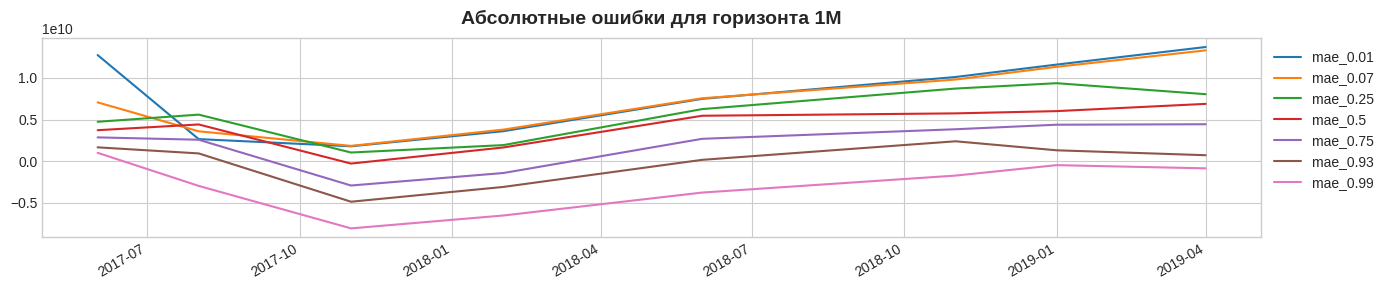

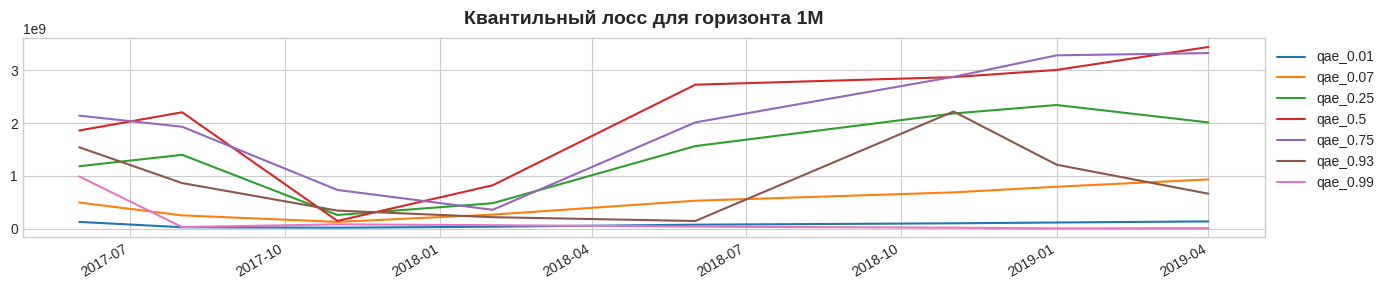

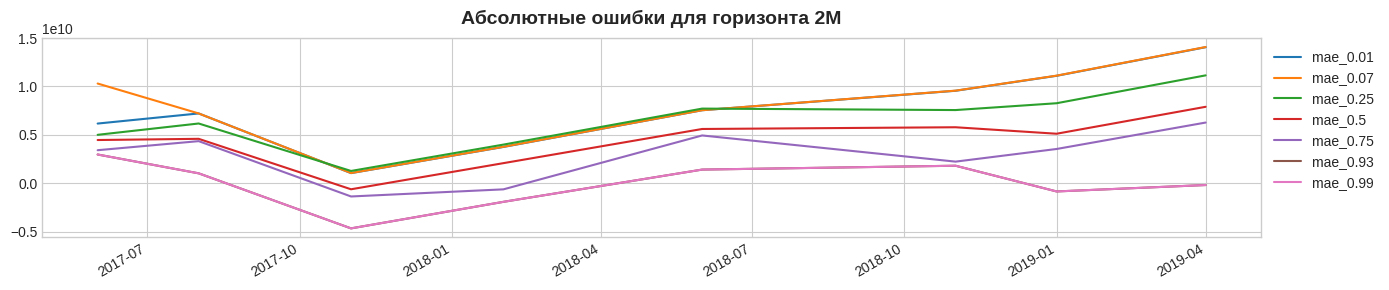

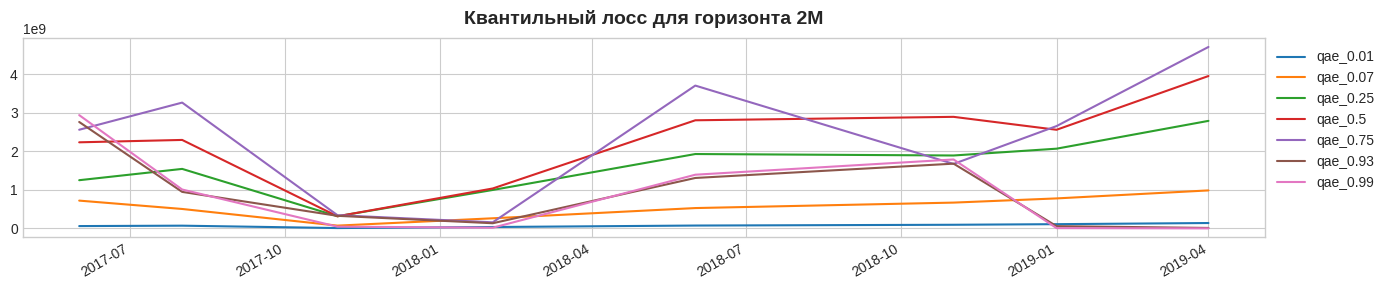

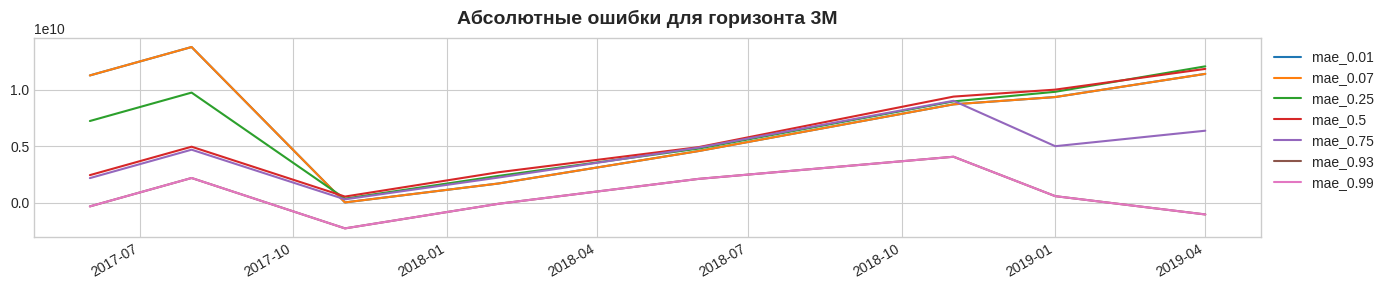

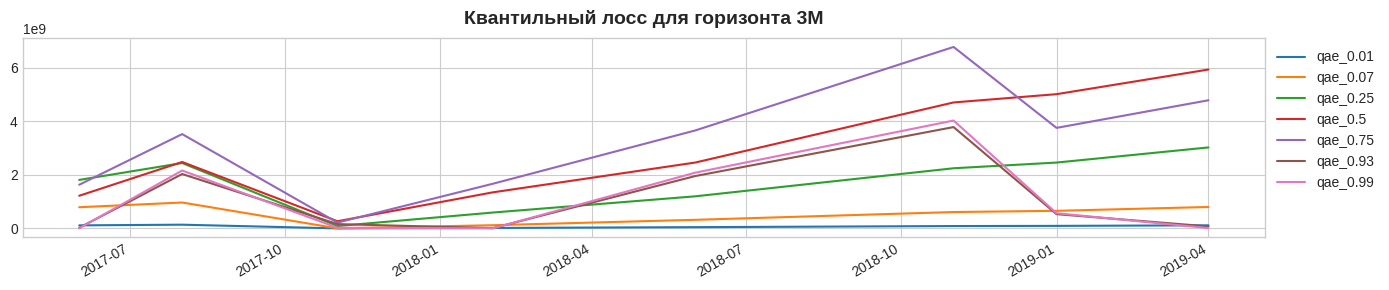

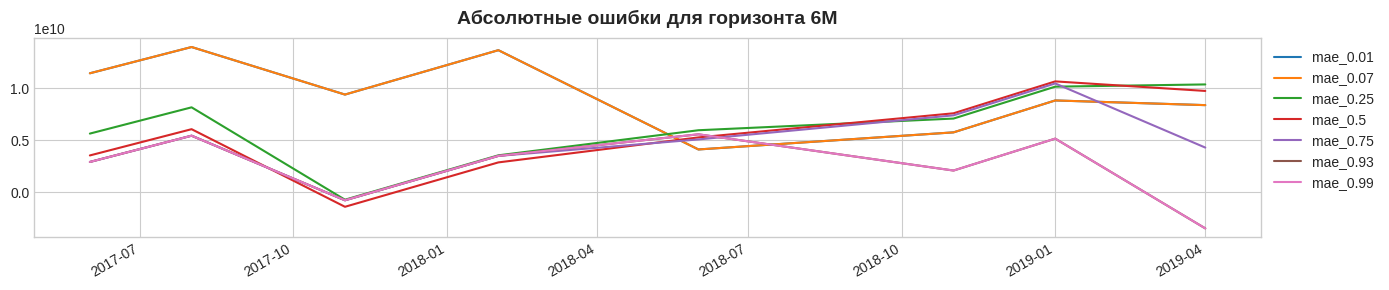

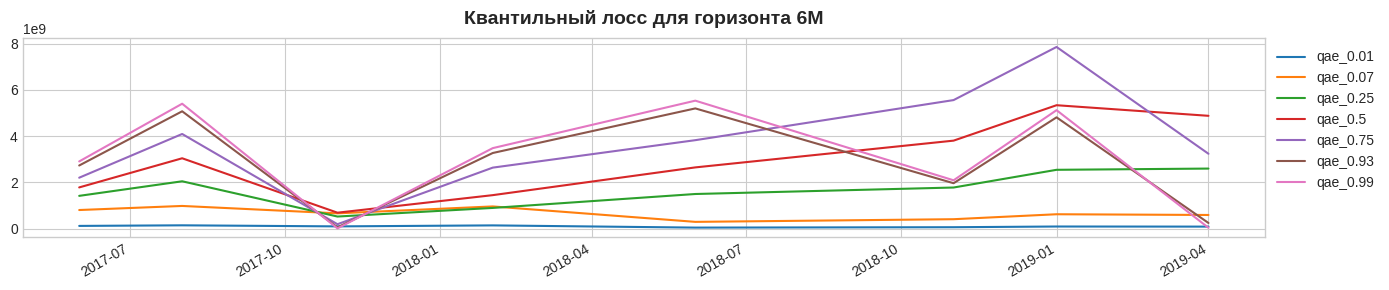

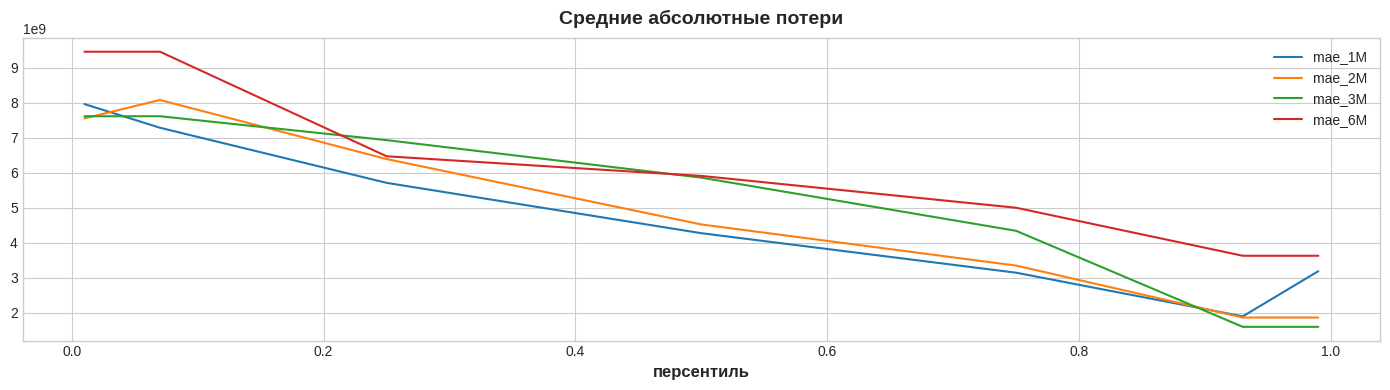

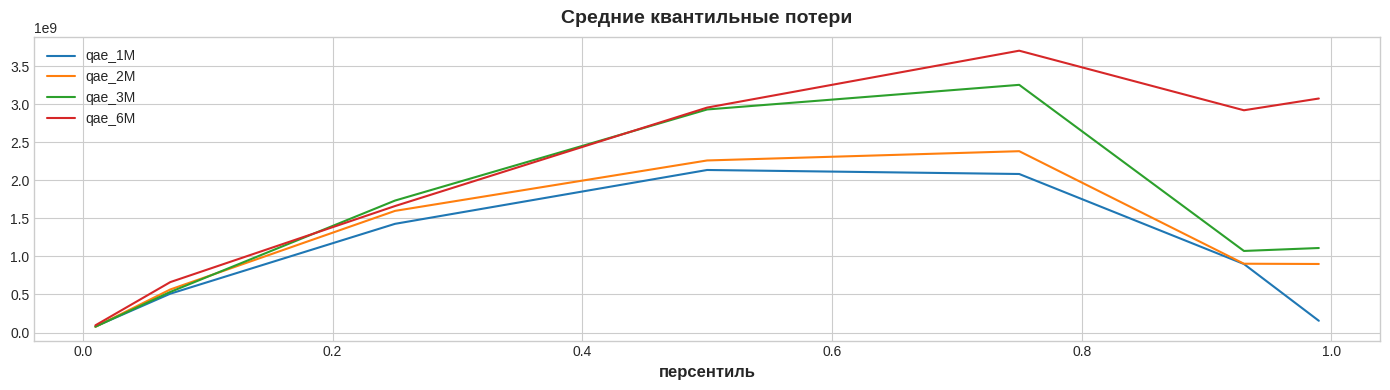

In [ ]:
# создание параметров наборов данных
limits = ['2017-06-01', '2017-08-01', '2017-11-01',
          '2018-02-01', '2018-06-01', '2018-11-01',
          '2019-01-01', '2019-04-01']
horizons = ['1M', '2M', '3M', '6M']
quantiles = [0.01, 0.07, 0.25, 0.5, 0.75, 0.93, 0.99]


#  ф-я получения абсолютной и квантильной ошибок предсказания
def get_errors(q, limit, horizon):
    # получаем предсказание
    y_fore = my_sm.forecast(
        limit=limit,
        horizon=horizon,
        model=QuantileRegressor(
            quantile=q, alpha=0, solver="highs"
        )
    )[0]
    # получаем реальное значение
    y_true = cropped_df[cropped_df.index >= limit].\
        resample(horizon).agg('min').iloc[0, 0]
    # находим абсолютную ошибку
    err = y_true-y_fore
    # квантильную
    q_err = np.maximum(q * err, (q - 1) * err)
    return q_err, err

# ф-я тестирования
def SM_testing(
        limits=limits,
        horizons=horizons,
        quantiles=quantiles
    ):


    # df для сбора ошибок
    error_df = pd.DataFrame(index =  quantiles)

    for horizon in horizons:
        # словарик для сбора средних ошибок
        mean_ae = {}
        q_ae = {}

        fore_df = pd.DataFrame(
            {q: limits for q in quantiles},
            columns=quantiles,
            index = pd.to_datetime(limits,format='%Y/%m/%d')
            )
        for q in fore_df.columns:
            fore_df[q] = fore_df[q].\
                apply(lambda limit: get_errors(q, limit, horizon))
            fore_df[f'mae_{q}'] = fore_df[q].apply( lambda x: x[1])
            fore_df[f'qae_{q}'] = fore_df[q].apply( lambda x: x[0])
            mean_ae[q] = [(fore_df[f'mae_{q}'].apply(np.abs)).mean()]
            q_ae[q] = [(fore_df[f'qae_{q}']).mean()]

        error_df[f'mae_{horizon}'] = pd.DataFrame(mean_ae).T

        error_df[f'qae_{horizon}'] = pd.DataFrame(q_ae).T

        # нарисуем ошибки по горизонтам
        fore_df.filter(like='mae').plot(
            title = f'Абсолютные ошибки для горизонта {horizon}',
        )
        plt.legend(loc="upper left", bbox_to_anchor=(1,1))

        fore_df.filter(like='qae').plot(
            title = f'Квантильный лосс для горизонта {horizon}',
        )
        plt.legend(loc="upper left", bbox_to_anchor=(1,1))

    # нарисуем средние абсолютные и квантильные потери
    error_df.filter(like='mae').plot(
        title = 'Средние абсолютные потери',
        xlabel="персентиль",
        figsize=(14,4)
    )

    error_df.filter(like='qae').plot(
        title = 'Средние квантильные потери',
        xlabel="персентиль",
        figsize=(14,4)
    )

    pass


SM_testing()

# Выводы:
Перед нами стояла задача построить модель, которая оценивает объем стабильной части средств на дату. В качестве входных данных должны были быть использованы :
- дата, до которой используется история наблюдений
- размер горизонта предсказаний.
- и данные на основе которых строится предсказание.  
  
Требовалось минимизировать величины:  
- максимальный объем пробития стабильный части на валидационной выборке
- фактическая стабильная часть – модельная стабильная часть  
    
Поставленная задача была выполнена с использованием модели построеной на основе __[QuantileRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.QuantileRegressor.html)__ .
  
Был проведён анализ работы модели для различных вариантов истории наблюдений, горизонтов и предсказываемых персентилей. Оценка предсказаний проводилась по мерикам:
- абсолютная ошибка
- квантильные потери.
  
По результатам исследования были сделаны следующие выводы:
- выбор модели с наименьшей абсолютной ошибкой приводит к увеличению максимального объёма пробития и не вполне соответствует поставленой задаче.
- модель с меньшей персентилью уменьшает квантильные потери и вероятность пробития  предсказанной стабильной части, но при выборе персентили  следует помнить, что происходит это уменьшение за счёт занижения величины предсказанной стабильной части и может увеличить абсолютную ошибку.
- интересно отметить , что модель предсказавающая 99 персентиль на малом горизонте стремиться к значению квантильной ошибки 1 персентильной модели, опять же ясно, что предсказания этой модели будут иметь иметь очень высокую вероятность пробития.  
     
Модель квантильной регрессии позволяет решить поставленную задачу.
 - если приоритет отдаётся снижению вероятности пробития следует выбрать модель с низкой персентилью
 - если важнее минимизировать ошибку оценки стабильной части то с высокой.
 - результаты предсказания модели хорошо интерпретируемы.

## Заключение
Заметим, что для повышения точности предсказания, можно провести более глубокий анализ данных, собрать экзогенные признаки, попробовать другие модели (от классической модели  Хольта-Винтера до нейронных сетей)  и применить другие метрики... Однако в данном задании такой цели поставлено не было , потому не будем излишне загромождать решение.